In [1]:
import Bio.PDB.PDBParser
from Bio.PDB.Polypeptide import protein_letters_3to1

import numpy as np
import torch

import open3d as o3d

In [94]:
def extract_point_clouds_N_Ca_C_O(pdb_filename: str, cath_id: str):
  # https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings
  import warnings
  warnings.filterwarnings("ignore")

  pdb_parser = Bio.PDB.PDBParser()
  structure = pdb_parser.get_structure(cath_id, pdb_filename)

  # Expect only one model per structure.
  assert(len(structure) == 1)

  points_N = []
  points_Ca = []
  points_C = []
  points_O = []

  for residue in structure.get_residues():
    for a in residue.get_atoms():
      name = a.get_fullname().strip()

      if name == 'N':
        points_N.append(a.get_coord())
      elif name == 'CA':
        points_Ca.append(a.get_coord())
      elif name == 'C':
        points_C.append(a.get_coord())
      elif name == 'O':
        points_O.append(a.get_coord())

  return [torch.Tensor(l) for l in [points_N, points_Ca, points_C, points_O]]


def center_and_scale_unit_sphere(points: torch.Tensor) -> torch.Tensor:
  mu = points.mean(dim=0)
  vmax, _ = points.max(dim=0)
  vmin, _ = points.min(dim=0)
  max_dim = (vmax - vmin).norm()
  points = 2 * (points - mu) / max_dim
  return points + 0.5


def center_and_scale_unit_box(points: torch.Tensor) -> torch.Tensor:
  mu = points.mean(dim=0)
  # Min and max corners of the bounding box.
  vmax = torch.Tensor([points[:,0].amax(), points[:,1].amax(), points[:,2].amax()])
  vmin = torch.Tensor([points[:,0].amin(), points[:,1].amin(), points[:,2].amin()])
  sf = 1.0 / (vmax - vmin + 1).max() # largest bbox dimension
  centered = (points - mu)
  return (centered * sf) + 0.5

In [95]:
cath_id = "1a0gA02"
pdb_filename = f"../data/pdb_share/16pkA02.pdb"
points_N, points_Ca, points_C, points_O = extract_point_clouds_N_Ca_C_O(pdb_filename, cath_id)

In [96]:
points_N_cent = center_and_scale_unit_box(points_N)
points_C_cent = center_and_scale_unit_box(points_C)
points_Ca_cent = center_and_scale_unit_box(points_Ca)
points_O_cent = center_and_scale_unit_box(points_O)

In [93]:
points_N_cent.max(dim=0)

torch.return_types.max(
values=tensor([0.8593, 0.9831, 1.0002]),
indices=tensor([ 97, 100, 167]))

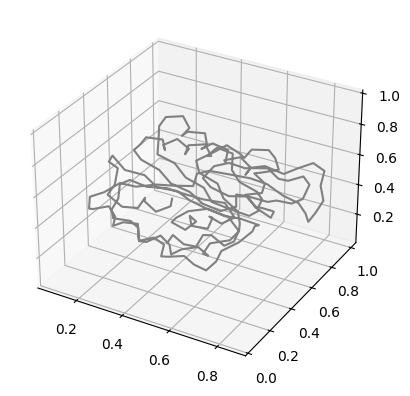

In [97]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')

points = points_N_cent

xline = points[:,0]
yline = points[:,1]
zline = points[:,2]
ax.plot3D(xline, yline, zline, 'gray')

In [ ]:
v = o3d.utility.Vector3dVector(points_Ca_cent)
pcd = o3d.geometry.PointCloud(v)

voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(
  pcd, voxel_size=0.01
)
voxels = voxel_grid.get_voxels()  # returns list of voxels
indices = np.stack(list(vx.grid_index for vx in voxels))
colors = np.stack(list(vx.color for vx in voxels))

In [ ]:
indices.max()

In [60]:
points = torch.Tensor([
  [0, -4, 0],
  [-1, 2, 0]
])

mu = points.mean(dim=0)
vmax = torch.Tensor([points[:,0].amax(), points[:,1].amax(), points[:,2].amax()])
vmin = torch.Tensor([points[:,0].amin(), points[:,1].amin(), points[:,2].amin()])
max_dim = (vmax - vmin).max() # largest bbox dimension
points = (points - mu) * (1 / max_dim)

In [64]:
points

tensor([[ 0.0833, -0.5000,  0.0000],
        [-0.0833,  0.5000,  0.0000]])